In [25]:
import os
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import polars as ps
import pandas as pd
import pymc3 as pm

from IPython.display import SVG, display
from pandas.plotting import parallel_coordinates
from scipy import stats
from theano import shared, tensor

# No.01

In [26]:
np.random.seed(seed=37710)
az.style.use('arviz-darkgrid')

In [27]:
dataset = ps.read_csv('dataset/howell.csv')

In [28]:
dataset.head()

height,weight,age,male
f64,f64,f64,i64
151.765,47.8256065,63,1
139.7,36.4858065,63,0
136.525,31.864838,65,0
156.845,53.0419145,41,1
145.415,41.276872,51,0


In [29]:
over_18_dataset = dataset.filter(ps.col('age') > 18)

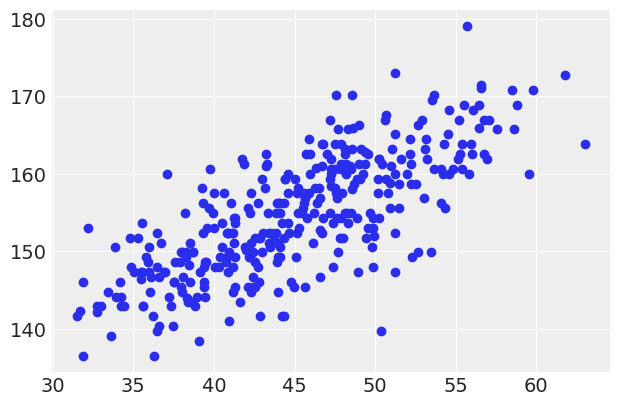

In [30]:
plt.scatter(x=over_18_dataset['weight'], y=over_18_dataset['height'])

In [31]:
with pm.Model() as over_18_heights:
    α = pm.Normal('α', sd=10)
    β = pm.Normal('β', sd=10)
    ϵ = pm.HalfNormal('ϵ', sd=10)

    weight_shared = shared(over_18_dataset['weight'].to_numpy())
    μ = pm.Deterministic('μ', α + β * weight_shared)

    height_pred = pm.Normal('height_pred', mu=μ, sd=ϵ, observed = over_18_dataset['height'].to_numpy())
    trace_over_18_heights = pm.sample(tune=2000)
    ppc_over_18_heights = pm.sample_posterior_predictive(trace_over_18_heights, samples=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ϵ, β, α]
Sampling 4 chains: 100%|██████████| 10000/10000 [00:02<00:00, 4619.17draws/s]
The acceptance probability does not match the target. It is 0.8795423675296842, but should be close to 0.8. Try to increase the number of tuning steps.
100%|██████████| 2000/2000 [00:00<00:00, 6094.46it/s]


/home/hermeschen/.pyenv/versions/miniconda3-latest/envs/BDA/lib/python3.6/site-packages/arviz/data/io_pymc3.py:78: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  log_likelihood, dims = self._extract_log_likelihood()


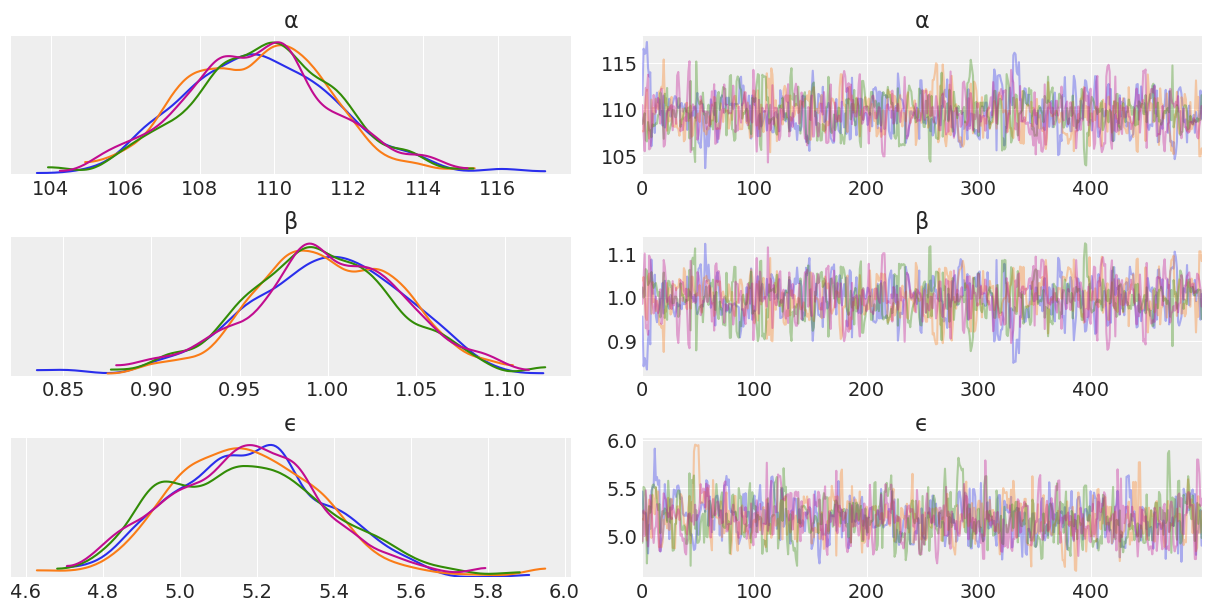

In [32]:
az.plot_trace(trace_over_18_heights, var_names = ["α","β", "ϵ"]);

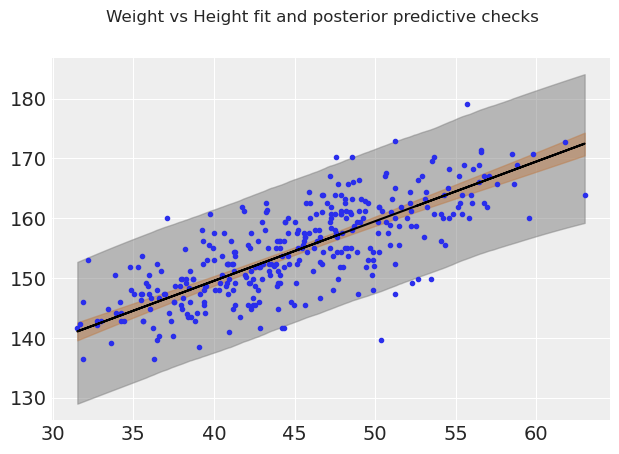

In [33]:
fig, ax = plt.subplots()

ax.plot(over_18_dataset['weight'].to_numpy(), over_18_dataset['height'].to_numpy(), "C0.")
μ_m = trace_over_18_heights["μ"].mean(0)
ϵ_m = trace_over_18_heights["ϵ"].mean()

ax.plot(over_18_dataset['weight'].to_numpy(), μ_m, c="k")
az.plot_hpd(over_18_dataset['weight'], trace_over_18_heights["μ"], credible_interval=.98)
az.plot_hpd(over_18_dataset['weight'], ppc_over_18_heights["height_pred"], credible_interval=.98, color="gray")
fig.suptitle("Weight vs Height fit and posterior predictive checks");